#### CRM raw 2023 deal dataset exploration

A deal here represents a CRM entity for one-off product sale to a customer rather than a subscription sale. Deals follow a straightforward methodology, a new deal is created when new sales opportunity is identified and confirmed; any deal will be closed as won or lost over a period of time called the sales cycle.  

Deals are associated with customer accounts aka companies; this should be one (company) to (many) deals association. Few attributes of companies are present in the deal dataset. Deals are devided into first sale to a new customer and the repetead or 2nd+ sales; first deals are as well attributed to the particular sales channel recorded in the deal_source variable. We presume that 1st deals are in 1-1 relationship to their customer companies, more exacttly each company having 1 (or 0) 1st deals and each first deal is associated with one and only one company.  

As the case with real life data there are number of inconsistencies and errors in the dataset, let it be discovered it we move on with the exploration. 

In [304]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [305]:
# file2read = '/Users/andrew/Documents/2023 JUPYTER Notebook/swag42 notebooks/\
# data/hubspot-crm-exports-deals-all-pieplienes-export-v-20240131-(excl 2 Niall prop deals.csv'

file2read = 'data/2023 raw deal dataset_1.csv'

df = pd.read_csv(file2read) #, index_col = 'Record ID')

In [306]:
# df.columns
df.shape

(934, 14)

## ___Pre-processing___

In [307]:
#column names for conv
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [308]:
#convert dates column into date types
df[['create_date', 'close_date']] = df[['create_date', 'close_date']]\
                                     .apply(pd.to_datetime)

In [310]:
# categorical type for deal_source for ordering
deal_source_ordered = ['Inbound', 'Outbound', 'Field/Offline event', 'Partner referrals', 'Other', 'Existing customer']

deal_source_categories =  pd.Categorical(df.deal_source, categories = deal_source_ordered, ordered = True)

type_deal_source_cats = pd.CategoricalDtype(categories = deal_source_ordered, ordered = True)

In [311]:
# deal_source categorical
df.deal_source = df.deal_source.astype(type_deal_source_cats)

In [313]:
deal_source_stat = pd.DataFrame(df.deal_source.value_counts( dropna = False).sort_index())
deal_source_stat['weight_%'] = df.deal_source.value_counts(normalize = True, dropna = False) * 100 
deal_source_stat

,count,weight_%
deal_source,,
Inbound,181,19.38
Outbound,174,18.63
Field/Offline event,68,7.28
Partner referrals,5,0.54
Other,52,5.57
Existing customer,454,48.61


In [314]:
df.describe()

,record_id,close_date,int_related_company_hc,amount_in_company_currency,create_date
count,934.00,934,932.00,934.00,934
mean,"8,637,859,059.50",2023-10-08 19:48:14.646680832,861.30,"9,236.13",2023-08-15 18:15:47.537473536
min,"6,638,455,006.00",2023-02-28 16:47:00,2.00,0.00,2023-02-10 14:34:00
25%,"7,537,225,687.00",2023-07-04 19:48:15,51.75,"2,000.00",2023-05-23 21:32:30
50%,"8,732,557,677.50",2023-10-17 02:54:00,200.00,"4,087.31",2023-08-30 01:56:00
75%,"9,610,180,447.50",2023-12-27 10:36:00,600.00,"9,355.36",2023-11-03 09:33:30
max,"10,681,144,050.00",2024-12-19 14:16:00,"69,778.00","350,000.00",2024-01-30 10:49:00
std,"1,166,804,103.62",NaN,"3,579.04","20,747.67",NaN


In [315]:
#df.head()
#df.info()
df.isnull().sum()

record_id                         0
deal_name                         0
deal_stage                        0
close_date                        0
associated_company                0
int_related_company_hc            2
int_related_company_industry    177
pipeline                          0
amount_in_company_currency        0
create_date                       0
deal_source                       0
associated_company_ids            0
associated_contact_ids            4
deal_owner                        5
dtype: int64

In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   record_id                     934 non-null    int64         
 1   deal_name                     934 non-null    object        
 2   deal_stage                    934 non-null    object        
 3   close_date                    934 non-null    datetime64[ns]
 4   associated_company            934 non-null    object        
 5   int_related_company_hc        932 non-null    float64       
 6   int_related_company_industry  757 non-null    object        
 7   pipeline                      934 non-null    object        
 8   amount_in_company_currency    934 non-null    float64       
 9   create_date                   934 non-null    datetime64[ns]
 10  deal_source                   934 non-null    category      
 11  associated_company_ids        93

In [317]:
df[['pipeline','deal_stage'] ].value_counts(dropna = False).sort_index()

pipeline          deal_stage       
Account Exec      Closed lost          307
                  Closed won           267
                  Contract sent          8
                  Design/Estimation     31
                  Presentation          38
                  Proposal sent         17
Customer Success  Closed lost           68
                  Closed won           136
                  Contract sent         13
                  Design/Estimation     18
                  Presentation          21
                  Proposal sent         10
Name: count, dtype: int64

In [318]:
#split ID's stirngs into lists with dtype = string
# df['split_associated_contact_ids'] = df.associated_contact_ids.str.split(";")
df['split_associated_company_ids'] = df.associated_company_ids.str.split(";")

In [319]:
#check where a deal is associated with 1+ companies which in fact is an incosistency 
df[ df.split_associated_company_ids.apply(lambda x: len(x)) > 1]

,record_id,deal_name,deal_stage,close_date,associated_company,int_related_company_hc,int_related_company_industry,pipeline,amount_in_company_currency,create_date,deal_source,associated_company_ids,associated_contact_ids,deal_owner,split_associated_company_ids
195,8298572990,s-t.global - NY 2024 - Nikita,Closed won,2023-11-28 14:33:00,Smartteam;s-t.global,50.00,INFORMATION_TECHNOLOGY_AND_SERVICES,Account Exec,"29,493.43",2023-07-18 17:14:00,Inbound,9023975355;8054604736,1193251,Mykyta,"[9023975355, 8054604736]"
348,8461628618,Armenotech=Aps.Money - Merch - Nikita,Closed won,2023-10-12 19:48:00,Alfa Capital Holdings (Cyprus) Limited;Armenot...,120.00,INFORMATION_TECHNOLOGY_AND_SERVICES,Account Exec,"4,084.02",2023-08-01 23:20:00,Outbound,7058460383;8111065818,42551,Mykyta,"[7058460383, 8111065818]"
356,6892972737,Aventus Group - New Deal,Closed won,2023-05-26 17:24:00,Aventus IT;Aventus Group,122.00,LEGAL_SERVICES,Account Exec,"7,728.00",2023-03-15 09:16:00,Inbound,6944655583;7115967952,68501,Nastasiia,"[6944655583, 7115967952]"
549,8676604917,"Optibet - Hoodie, bomber, t-shirt",Closed won,2023-10-17 14:43:00,Enlabs;Optibet,300.00,MARKET_RESEARCH,Account Exec,"11,671.92",2023-08-24 09:21:00,Other,8300148415;8409566413,1730551,Mykyta,"[8300148415, 8409566413]"
749,8432151545,NY 2024 - Growe - Tanya,Closed won,2023-09-01 09:49:00,Pmi;Growe,700.00,COMPUTER_SOFTWARE,Account Exec,"210,000.00",2023-07-29 12:20:00,Other,7906141662;8310276089,1741501;735751;1794751;1508951;966701,Tanya,"[7906141662, 8310276089]"


In [320]:
#for simplicity get the first company ID into the add column
df['ass_company_id_1st'] = df.split_associated_company_ids.apply(lambda x: x[0])

In [322]:
df.columns

Index(['record_id', 'deal_name', 'deal_stage', 'close_date',
       'associated_company', 'int_related_company_hc',
       'int_related_company_industry', 'pipeline',
       'amount_in_company_currency', 'create_date', 'deal_source',
       'associated_company_ids', 'associated_contact_ids', 'deal_owner',
       'split_associated_company_ids', 'ass_company_id_1st'],
      dtype='object')

In [323]:
#Drop the columns we will not need further on

col2drop= [ 
        #'record_id', 
       'deal_name', 
        #'Deal_Stage', 'close_date', 'deal_owner',
        #'Associated_Company', 'int_related_company_hc', 'pipeline',
        #'amount_in_company_currency', 'create_date', 'deal_source',
        #'Associated_Contact', 
       'associated_company_ids',
       'associated_contact_ids', 
       'split_associated_company_ids', 
        #'Ass_Company_ID_1st'
        ]

deals = df.drop(col2drop, axis = 1)\
                                    .copy()

## Error fixes

In [324]:
#reinstate Mads for 5 no owner deals
deals.deal_owner = deals.deal_owner.fillna('Mads')

In [325]:
#drop rows with NaN for int_related_company_hc
deals = deals.dropna(subset = 'int_related_company_hc')

In [326]:
# deals.isnull().sum()
# deals.shape

In [327]:
#get a slice for 1st deals created in 2023
first_deals_raw = deals.query('deal_source != "Existing customer" and create_date < "2024-01-01" and pipeline != "Customer Success"')

In [328]:
first_deals_raw.rename()

(451, 12)

### Checking multiple first deals related with one company

In [662]:
tmp_cos_pre = pd.DataFrame(
    first_deals_raw.groupby('ass_company_id_1st')
    .agg(
    {
    'create_date' : lambda x: list(x.dt.date),
    'deal_source' : lambda x: list(x),
    'record_id' : len
    }
).sort_values('record_id', ascending = False)
    .record_id
    .value_counts()
).rename(columns={'count':'# of accounts'})

tmp_cos_pre.index = tmp_cos_pre.index.rename('# of the associated 1st deals')
tmp_cos_pre

,# of accounts
# of the associated 1st deals,
1,341
2,42
3,6
4,2


There multiple 1st deals related with one account, this is an error! For simple let's fix these by taking an earlies deal associated with the given company account

In [663]:
# mask rows that contain earliest first deal for a company
first_deals_mask = first_deals_raw.groupby('ass_company_id_1st').create_date.transform(lambda x: x == min(x))

In [664]:
# tmp_cos_post = first_deals_raw[ first_deals_first ]\
# .groupby('ass_company_id_1st').agg(
#     {
#     'create_date' : lambda x: list(x.dt.date),
#     'deal_source' : lambda x: list(x),
#     'record_id' : len
#     }
# )

In [665]:
# check_join = (
#     tmp_cos_pre.join(tmp_cos_post, lsuffix = '_l', rsuffix = '_r', validate = "one_to_one" )
#     .sort_values('record_id_l', ascending = False)
# )

In [666]:
# checkin manually - worked
# check_join.head(5)

In [667]:
first_deals = first_deals_raw[ first_deals_mask ].copy()

In [668]:
first_deals.shape

(391, 12)

In [669]:
deal_source_stat = pd.DataFrame(first_deals.deal_source.value_counts( dropna = False))
deal_source_stat['weight_%'] = first_deals.deal_source.value_counts(normalize = True, dropna = False) * 100 
deal_source_stat.loc['Total',:] = deal_source_stat.sum()
deal_source_stat

,count,weight_%
deal_source,,
Inbound,153.00,39.13
Outbound,136.00,34.78
Field/Offline event,56.00,14.32
Other,42.00,10.74
Partner referrals,4.00,1.02
Existing customer,0.00,0.00
Total,391.00,100.00


In [550]:
# Remove unused categories for deal_source for first_deals excluding Existing deals
first_deals.deal_source = first_deals.deal_source.cat.remove_unused_categories()

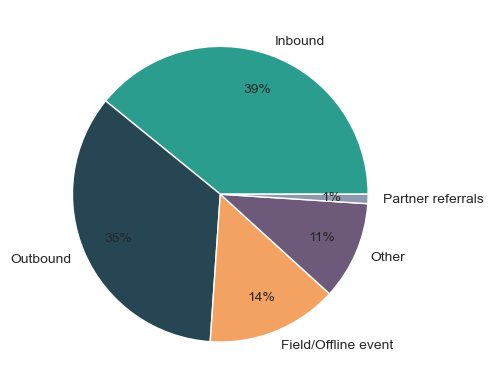

In [616]:
first_deals.deal_source.value_counts().plot(
    kind='pie', 
    colors = dsource_colors.values(), 
    ylabel="", 
    autopct='%1.f%%',  
    pctdistance=0.75
);

Deal created weights across deal (lead) sources over the reviewd 2023 period as a pie-chart

In [567]:
first_deals['create_quarter'] = first_deals.create_date.dt.quarter

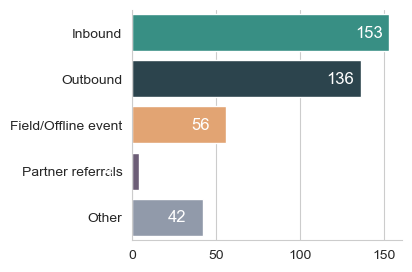

In [625]:
g = sns.catplot(
    first_deals, 
    y = 'deal_source', 
    kind = 'count', 
    hue = 'deal_source', 
    palette = dsource_colors, 
    height = 3, 
    aspect = 1.5
);


for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(
            container, 
            label_type= 'edge', # 'edge' puts it just above/outside, 'center' puts it inside
            padding= -25,       # Negative padding moves the label inside the bar
            color= 'white',     # Change color so it's visible against the bar
            fontsize= 12,
            # fontweight= 'bold'
        )

g.set_titles("2023 deals created")
g.set_axis_labels("", "")

plt.show()

Deal created counts across deal (lead) sources over the reviewd 2023 period

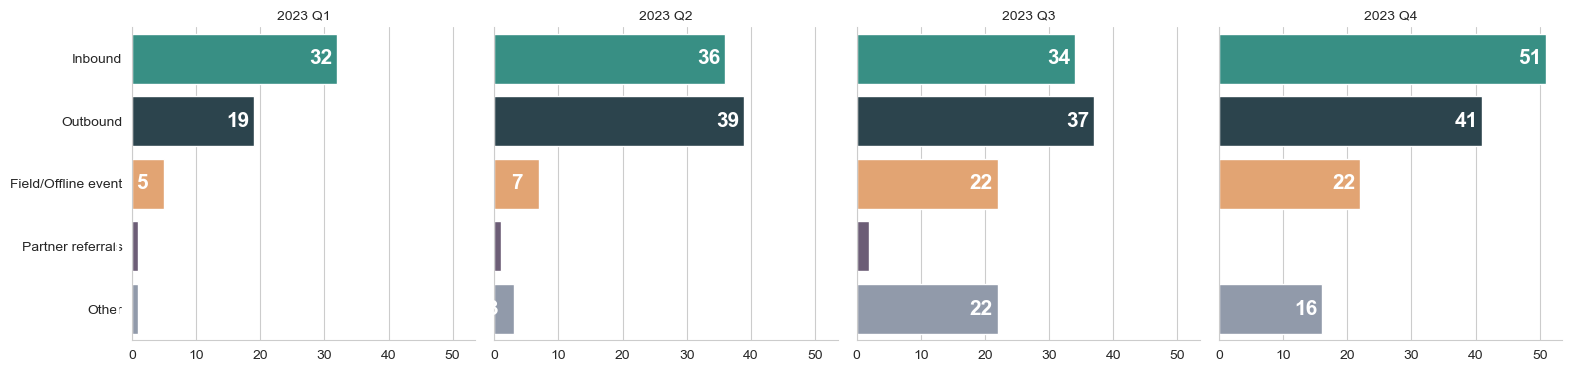

In [610]:
sns.set_style("whitegrid")

g = sns.catplot(
    data= first_deals,
    y= "deal_source",
    col= "create_quarter",
    kind= "count",
    hue = "deal_source",
    palette= dsource_colors,
    height= 4,
    aspect= 1
)

# 2. Add count labels inside the bars
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(
            container, 
            label_type='edge', # 'edge' puts it just above/outside, 'center' puts it inside
            padding=-20,       # Negative padding moves the label inside the bar
            color='white',     # Change color so it's visible against the bar
            fontsize=15,
            fontweight='bold'
        )

        
g.set_titles("2023 Q{col_name}")
g.set_axis_labels("", "")

## __Look at univariate distributions for 1st deals size and for account size__

In [626]:
#check data for deal amounts, it's skewed indeed
pd.options.display.float_format = '{:,.2f}'.format

first_deals.amount_in_company_currency.describe()

count       391.00
mean      7,768.92
std      15,965.63
min           0.00
25%       2,000.00
50%       4,090.41
75%       7,801.50
max     224,390.17
Name: amount_in_company_currency, dtype: float64

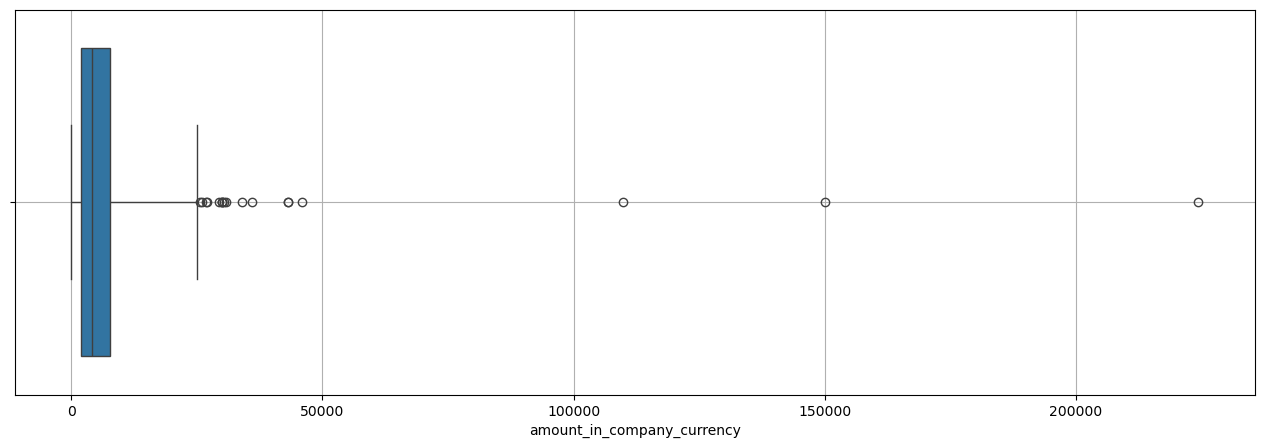

In [342]:
#boxplot, whiskers = 3IQR
plt.figure(figsize = (16,5))
sns.boxplot(x = first_deals.amount_in_company_currency, whis = 3)

plt.grid()

In [343]:
#check data for deal amounts, it's skewed too
first_deals.int_related_company_hc.describe()

count      391.00
mean       775.38
std      3,979.75
min          2.00
25%         50.00
50%        134.00
75%        420.50
max     69,778.00
Name: int_related_company_hc, dtype: float64

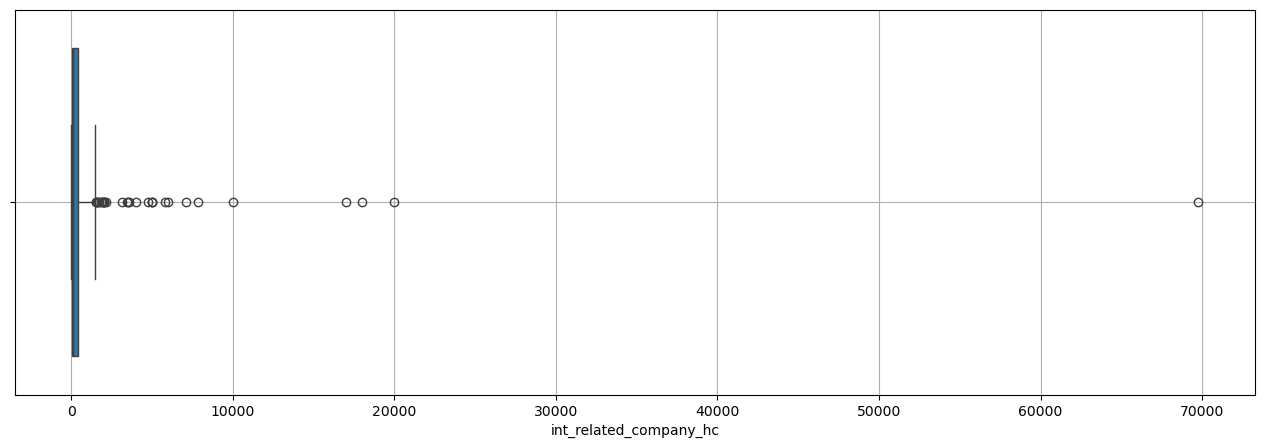

In [344]:
#take a look at boxplot, whiskers = 3IQR
plt.figure(figsize = (16,5))
sns.boxplot(x = first_deals.int_related_company_hc, whis = 3)

plt.grid()

In [627]:
def CalcUWhisker(series, n):
    return series.quantile(.75) + n * ((series.quantile(.75) - series.quantile(.25)))


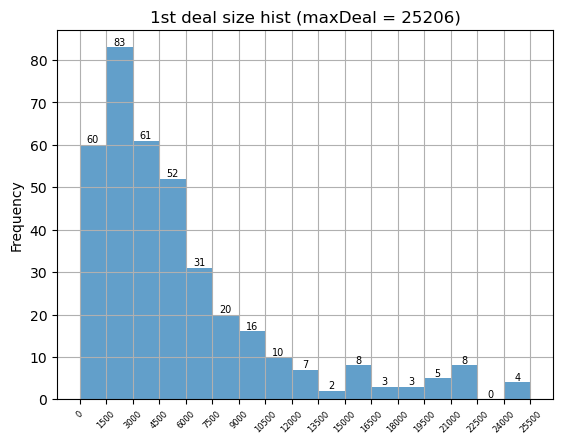

In [346]:
#fastplot 1st deal amounts hist, casting out outliers
maxDeal =  CalcUWhisker(first_deals.amount_in_company_currency, 3) #+3IQR
#maxDeal = first_deals.amount_in_company_currency.max()

binz = np.arange(0, maxDeal + 1500, 1500, dtype = np.int64)

ax = first_deals.amount_in_company_currency.\
                    plot(kind= 'hist', bins=  binz, grid = True, alpha = .7)

plt.title('1st deal size hist (maxDeal = {})'.format(round(maxDeal)))
plt.xticks(binz, fontsize= 6, rotation = 45)
ax.bar_label(ax.containers[0], fontsize= 7);

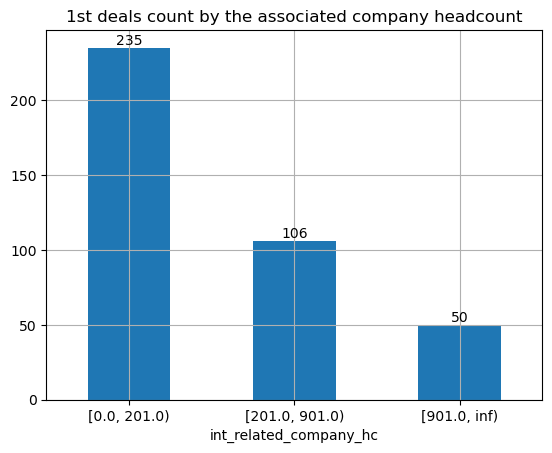

In [347]:
#check N of 1st deals  per Company sizes, work with custom bins  
ax = pd.cut(first_deals.int_related_company_hc, bins = [0, 201, 901, float('inf')], right = False)\
                        .value_counts()\
                        .plot(kind = 'bar', grid = True)

plt.title('1st deals count by the associated company headcount')
plt.xticks(rotation = 0)
ax.bar_label(ax.containers[0]);

Bins here correspond to the account size segmentaion as used by the company

## __Deal count distribution per industry?__

In [348]:
# first_deals.int_related_company_industry\
#                         .value_counts(dropna = False)

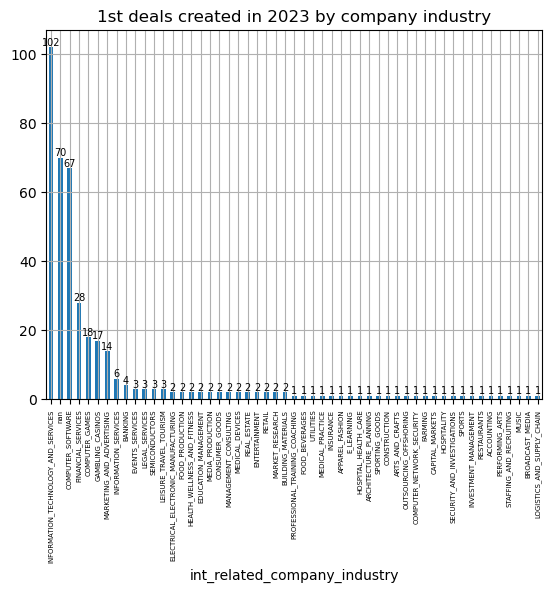

In [349]:
#check company Indusrty distribution for 1st deals as created  
ax = first_deals.int_related_company_industry\
                        .value_counts(dropna = False)\
                        .plot(kind = 'bar', grid = True)

plt.title('1st deals created in 2023 by company industry')
plt.xticks(rotation = 90, fontsize = 5)
ax.bar_label(ax.containers[0], fontsize = 7);

In [350]:
# group the Industry and get value_counts and it's percentage of the whole inc NaN which means industry unknown
ind_inc_nan = first_deals.groupby(['int_related_company_industry'], dropna = False)\
  .agg( 
        N_values = ('record_id', 'count'),
        Percent = ('record_id', lambda x: (100 * x.count() / first_deals.shape[0]).round(1))  
      )\
                       .sort_values(['N_values'], ascending = False)
#                       .head(15)

In [351]:
#check the industries that make up close to 80% of the occurrences
idx = np.argmin( np.abs( 80 - np.cumsum(ind_inc_nan.Percent.to_numpy() )))

ind_inc_nan.head(idx + 1)

,N_values,Percent
int_related_company_industry,,
INFORMATION_TECHNOLOGY_AND_SERVICES,102,26.10
NaN,70,17.90
COMPUTER_SOFTWARE,67,17.10
FINANCIAL_SERVICES,28,7.20
COMPUTER_GAMES,18,4.60
GAMBLING_CASINOS,17,4.30
MARKETING_AND_ADVERTISING,14,3.60


These 8 industries make up to ~80% of all deasl created. Improve industry labeling as NaN company industry accounts for 17% of all deals 

## __Headcount abnormal frequencies__

In [628]:
#we assumed that 1st deals are 1-1 with companies, checking headcounts frequencies
first_deals.groupby(['int_related_company_hc'])\
  .agg( 
        N_values = ('record_id', 'count'),
        Percent = ('record_id', lambda x: (100* x.count() / first_deals.shape[0]).round(1).astype('str') + '%')  
      )\
                       .sort_values(['N_values'], ascending = False)\
                       .head(10)

,N_values,Percent
int_related_company_hc,,
50.00,42,10.7%
500.00,18,4.6%
200.00,18,4.6%
10.00,15,3.8%
30.00,9,2.3%
"1,000.00",9,2.3%
201.00,9,2.3%
25.00,8,2.0%
100.00,7,1.8%


Since the company headcounts are rather rough numbers measures taken from manual sourcing process, that should rectified - or at least expected to - in the AE process, there are abnormal freaquencies for sharp numbers of 50, 500, 200 etc.  Sptreamline and improve account size definition process and accuracy.

In [532]:
# define uniform colors for deal_sources
dsource_colors = {
    'Inbound': '#2a9d8f',
    'Outbound': '#264653',
    'Field/Offline event': '#f4a261',
    'Partner referrals': '#6d597a',
    'Other': '#8d99ae',
    'Existing customer': '#e76f51'
}

## Deal counts accross account sizes - looking at each deal (lead) channel

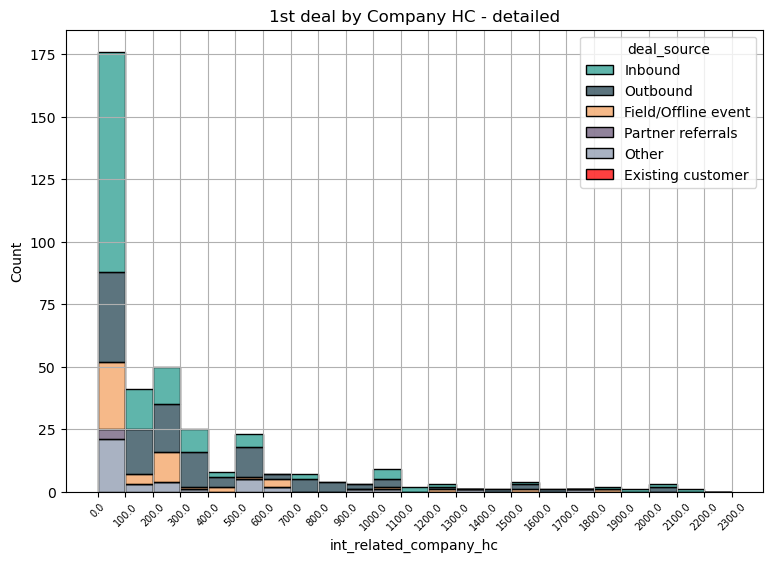

In [355]:
#add more details into N new deals vs company HC chart, color code the deal source
HC_upperbound: int = CalcUWhisker(first_deals.int_related_company_hc, 5) #2100 #for plot to fit

hc_bins = np.arange(0, HC_upperbound + 100, 100)
#deal_bins1 = np.sort( np.hstack((deal_bins, [210, 510, 1010]))) - adding custom bins

plt.figure(figsize = (9,6))

ax = sns.histplot(
             data = first_deals, 
             x = 'int_related_company_hc', 
             hue = first_deals.deal_source.astype(type_deal_source_cats),
             bins= hc_bins,
             palette= dsource_colors,
             # kde = True, 
             multiple = "stack"
            )


ax.set_xticks(hc_bins)
ax.set_xticklabels(ax.get_xticks(), size = 7)
ax.set_xticklabels(ax.get_xticks(), rotation= 45)
ax.set_title('1st deal by Company HC - detailed')
#ax.set_yticks(ticks=10, minor=True)

ax.grid()
plt.show()

Not much transpires from this visualization though

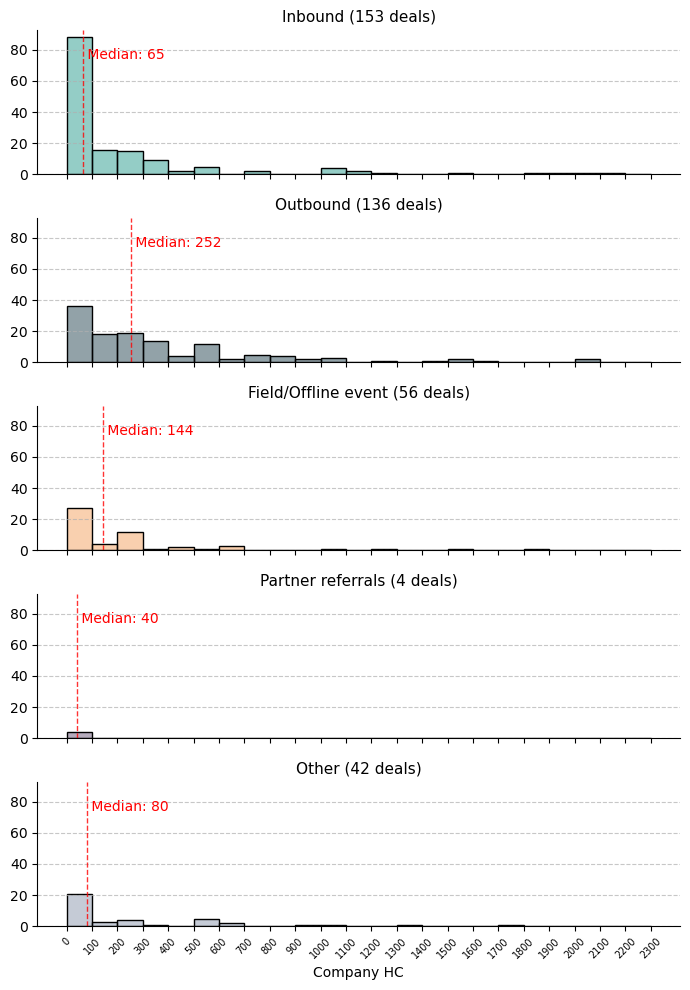

In [394]:
# 5 disrete charts for each of the deal sources
HC_upperbound = CalcUWhisker(first_deals.int_related_company_hc, 5)
hc_bins = np.arange(0, HC_upperbound + 100, 100)

# We use row="deal_source" to stack them vertically
g = sns.displot(
    data= first_deals, 
    x='int_related_company_hc', 
    row= 'deal_source',     # Creates 5 distinct charts stacked vertically
    #row = first_deals.deal_source.astype(type_deal_source_cats),
    hue= 'deal_source',     # Keeps the color coding
    palette= dsource_colors,
    bins= hc_bins,
    height= 2,               # Height of each individual chart
    aspect= 3.5,               # Width-to-height ratio
    facet_kws= {'sharey': True, 'sharex': True}, # Ensures all charts use the same scale
    legend=False
)

def draw_median_line(data, **kwargs):
    median_val = data.int_related_company_hc.median()
    ax = plt.gca()
    # Draw the vertical line
    ax.axvline(median_val, color='red', linestyle='--', lw=1, alpha=0.8)
    # Add a text label for the numeric median value
    ax.text(median_val, ax.get_ylim()[1] * 0.8, f' Median: {median_val:.0f}', 
            color='red', ha='left')

g.map_dataframe(draw_median_line)


deal_counts = first_deals.deal_source.value_counts()

for source_name, ax in g.axes_dict.items():
    n = deal_counts[source_name]
    ax.set_title(f"{source_name} ({n} deals)", size=11)

# 3. Refine the axes and labels
# g.set_titles("{row_name} - {row_name} ") # Labels each plot with the Deal Source name
g.set_axis_labels("Company HC", "")

# Adjusting ticks for the bottom chart
for ax in g.axes.flat:
    ax.set_xticks(hc_bins)
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Median opportunity account size different across the channels, 65 for Inbound, 252 for Outbound and 1444 for Field. Which shows that Outbound works as expected steering sales towards bigger customer accounts. in this regard Field is imposed more limitaiton by the available event audiences.

## __Explore dependency between deal amounts and company HC for each deal sources (scatterplots and corr's)__

In [508]:
#prep dataframe for plotting 
deal_source_plt = ['Inbound', 'Outbound', 'Field/Offline event']
first_deals_plt = first_deals.query('deal_source in @deal_source_plt').copy()

# remove unused cats
first_deals_plt.deal_source = first_deals_plt.deal_source.cat.remove_unused_categories()

In [485]:
# define func to draw 'Inbound', 'Outbound', 'Field/Offline event' in one horizontal plot

def drawing_func(first_deals_plt):
    
    g = sns.FacetGrid(
        first_deals_plt, 
        col= "deal_source", 
        hue = "deal_source", 
        palette = dsource_colors, 
        height = 4
    )

    g.map(
        sns.regplot, 
        'int_related_company_hc',
        'amount_in_company_currency',  
        scatter = True,
        #robust = True,
        scatter_kws=
        {
            's': 10,          # Marker size (s stands for area in points^2)
            'alpha': 0.7
        }
    )

    deal_counts = first_deals.deal_source.value_counts()

    for source_name, ax in g.axes_dict.items():
        n = deal_counts[source_name]
        ax.set_title(f"{source_name} ({n} deals)", size=11)

    # Add gridlines, rotate labels, and update titles with counts
    for ax in g.axes.flat:
        # Show gridlines
        ax.grid(True, linestyle='--', alpha=0.6)
        # Rotate x-axis labels and decrease font size
        ax.tick_params(axis='x', rotation=45, labelsize=9)

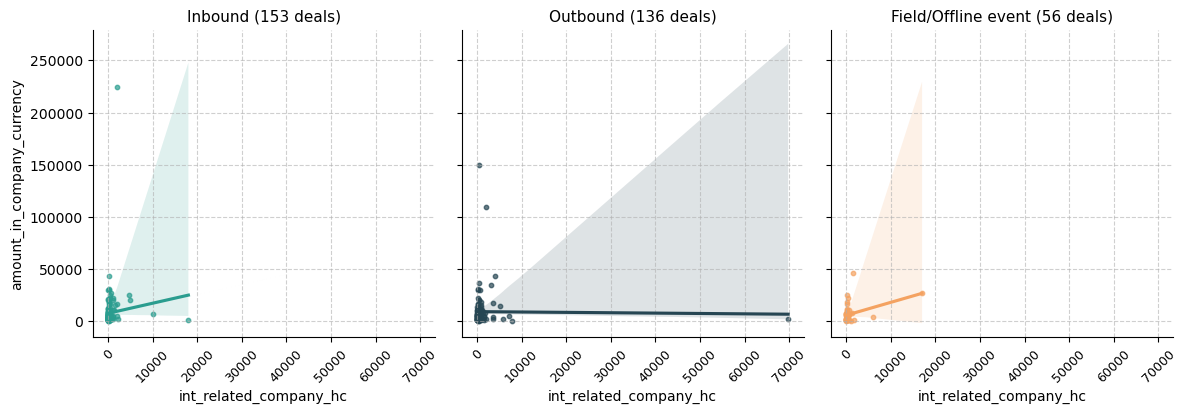

In [487]:
drawing_func(first_deals_plt)

In [477]:
#play with outliers

#naive 1 - remove only highest value int_related_company_hc for Outbound
mask_1 = ~first_deals_plt.eval('deal_source == "Outbound" and int_related_company_hc == int_related_company_hc.max()')

# naive 2 - discard top 3% of values separate for each deal_source
q_97 = .97
mask_2 = (
    first_deals_plt.groupby('deal_source', observed = True).amount_in_company_currency.transform(lambda col: col < col.quantile(q_97)) &
    first_deals_plt.groupby('deal_source', observed = True).int_related_company_hc.transform(lambda col: col < col.quantile(q_97))
)

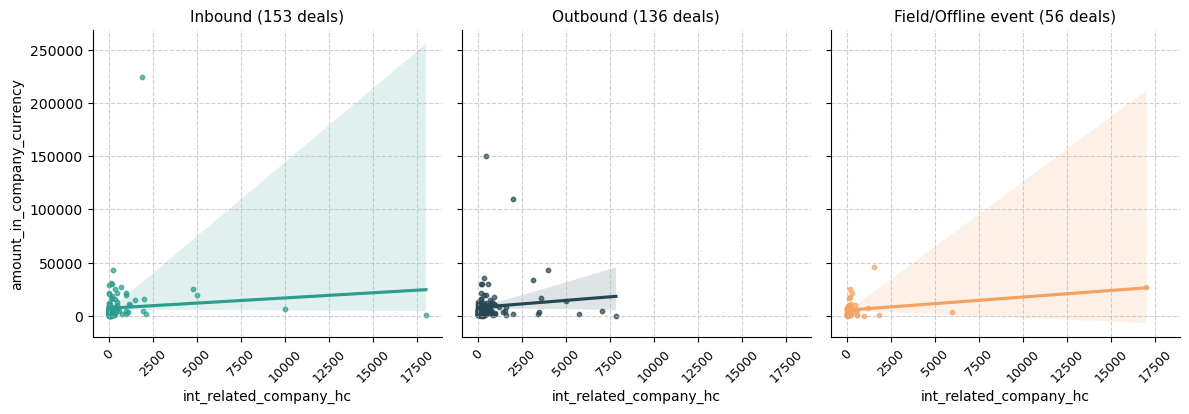

In [488]:
drawing_func(first_deals_plt[mask_1])

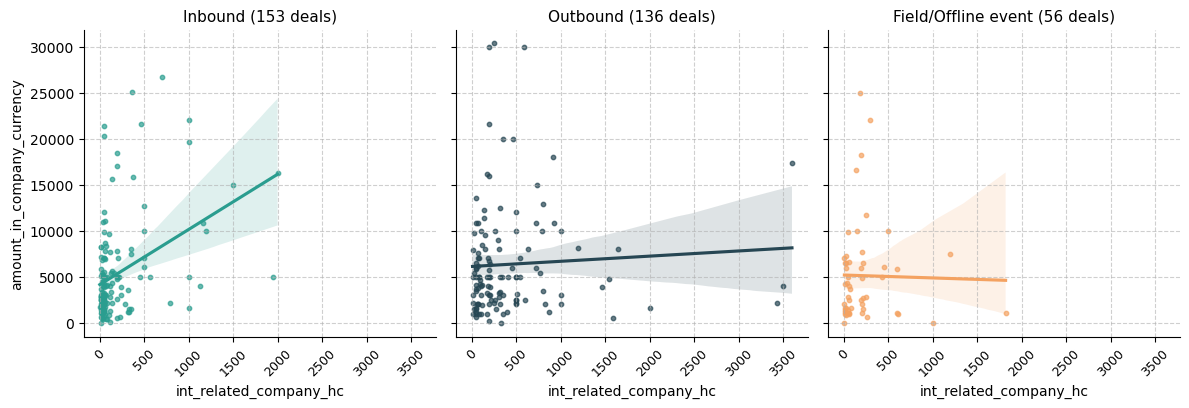

In [486]:
drawing_func(first_deals_plt[mask_2])

That's better, however is not quite rigorous. Try ranks and Spearman correlation

In [495]:
# get ranks dataframe
first_deals_plt_ranks = first_deals_plt.groupby('deal_source', observed = True)[['int_related_company_hc', 'amount_in_company_currency']].rank() 
first_deals_plt_ranks['deal_source'] = first_deals_plt.deal_source

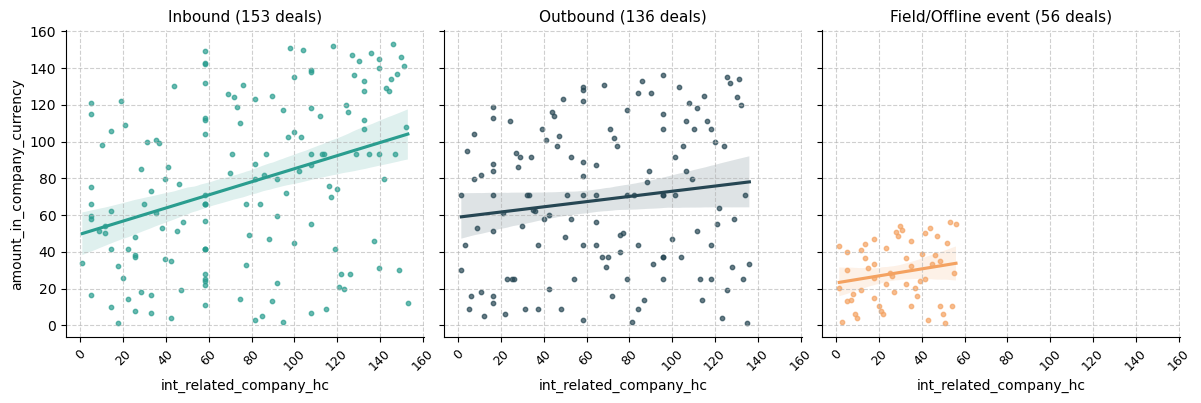

In [496]:
drawing_func(first_deals_plt_ranks)

## __Compute the correlations Pearson and Spearman__

In [497]:
from scipy.stats import pearsonr, spearmanr

In [498]:
def get_spearman(group):
    rho, p_val = spearmanr(group.iloc[:, 0], group.iloc[:, 1])
    return pd.Series({'spearman rho': rho, 'spearman p_value': p_val, 'count': group.shape[0]})

def get_pearson(group):
    rho, p_val = pearsonr(group.iloc[:, 0], group.iloc[:, 1])
    return pd.Series({'pearson rho': rho, 'pearson p_value': p_val, 'count': group.shape[0]})

In [506]:
pearson = (
    first_deals_plt.groupby('deal_source', observed = True)
    [['amount_in_company_currency', 'int_related_company_hc']]
    .apply(get_pearson)
    .astype({'count':int})
)
pearson.to_clipboard()
pearson

,pearson rho,pearson p_value,count
deal_source,,,
Inbound,0.09,0.27,153
Outbound,-0.01,0.88,136
Field/Offline event,0.37,0.01,56


In [503]:
pearson_wo_outliers_1 = (
    first_deals_plt[ mask_1 ]
    .groupby('deal_source', observed = True)
    [['amount_in_company_currency', 'int_related_company_hc']]
    .apply(get_pearson)
    .astype({'count':int})
)
pearson_wo_outliers_1

,pearson rho,pearson p_value,count
deal_source,,,
Inbound,0.09,0.27,153
Outbound,0.10,0.25,135
Field/Offline event,0.37,0.01,56


In [504]:
pearson_wo_outliers_2 = (
    first_deals_plt[ mask_2 ]
    .groupby('deal_source', observed = True)
    [['amount_in_company_currency', 'int_related_company_hc']]
    .apply(get_pearson)
    .astype({'count':int})
)
pearson_wo_outliers_2

,pearson rho,pearson p_value,count
deal_source,,,
Inbound,0.39,0.00,143
Outbound,0.06,0.51,126
Field/Offline event,-0.02,0.89,53


In [507]:
spearman = (
    first_deals_plt.groupby('deal_source', observed = True)
    [['amount_in_company_currency', 'int_related_company_hc']]
    .apply(get_spearman)
    .astype({'count':int})
)
spearman.to_clipboard()
spearman

,spearman rho,spearman p_value,count
deal_source,,,
Inbound,0.36,0.00,153
Outbound,0.14,0.10,136
Field/Offline event,0.19,0.16,56


Inbound:  
Pearson: $\rho \approx 0.09$ ($p = 0.27$) — Not statistically significant  
Spearman: $\rho \approx 0.36$ ($p < 0.00001$) — Highly significant  
Interpretation: There is a clear, reliable positive relationship here, but it isn't linear. likely outliers are breaking the Pearson calculation. However, the rank-order is consistent.

Outbound: The "Noise" Category  
Pearson: $\rho \approx -0.01$ ($p = 0.88$)  
Spearman: $\rho \approx 0.14$ ($p = 0.10$)  
Interpretation: Neither test shows a significant relationship at the standard $95\%$ confidence level ($p < 0.05$). The correlation is weak to non-existent. Outbound deals in this dataset don't seem to follow a predictable pattern based on the variables tested.

Field/Offline Events: The "Outlier" Suspect  
Pearson: $\rho \approx 0.37$ ($p = 0.005$) — Significant  
Spearman: $\rho \approx 0.19$ ($p = 0.16$) — Not significant  
Interpretation: This is the opposite of Inbound. Here, Pearson is strong but Spearman is weak. This usually happens when a few massive outliers are driving the correlation. With only 56 samples, one or two "whale" deals making it look like there’s a strong linear trend when the rest of the data is actually quite scattered. Results need to be taken with caution.


## __Explore deals closed in 2023__ 

In [676]:
#get slice for the deals closed in 2023 
closed_deals = deals[ deals.deal_stage.isin(['Closed won', 'Closed lost']) &\
                                         (deals.close_date < pd.to_datetime('2024-01-01')) ]

closed_deals_1st = first_deals[ first_deals.deal_stage.isin(['Closed won', 'Closed lost']) &\
                                         (first_deals.close_date < pd.to_datetime('2024-01-01')) ]


In [673]:
#closed_deals.info()
closed_deals.shape

(706, 12)

In [134]:
#1st and repeted deals apart
# closed_deals_1st = closed_deals.query('deal_source != "Existing customer" and pipeline != "Customer Success"')

closed_deals_2ndPlus = closed_deals.query('deal_source == "Existing customer"')

In [115]:
#closed_deals_1st.shape

#closed_deals_2ndPlus.shape

### __Winrates breakdown by deal source and Company HC__

In [681]:
#define winrate functions
funcN = lambda x: (x == 'Closed won').sum()/x.count() # calc winrate for N of deals
funcSum = lambda x: x[ closed_deals.deal_stage == 'Closed won' ].sum()/x.sum() #winrate for deal amount
funcMeanWon = lambda x: x[ closed_deals.deal_stage == 'Closed won' ].mean()

In [683]:
#Winrates by the deal source
cl_deals_gr3 = closed_deals_1st.groupby(by = [ 'deal_source'], observed = True)\
                                .agg( Winrate_N = ('deal_stage', funcN ),
                                      Winrate_Sum = ('amount_in_company_currency', funcSum ),
                                      N_values = ('deal_stage', 'count' ),
                                      Av_deal_cl = ('amount_in_company_currency', 'mean' ),
                                      Av_deal_Won = ('amount_in_company_currency', funcMeanWon )
                                     )\
                                .reset_index()


cl_deals_gr3.N_values.astype(int)

#proper display w heatmap stile formatting
cm = sns.light_palette("green", as_cmap = True)

cl_deals_gr3.style.format('{:.2f}', subset = ['Winrate_N','Winrate_Sum'])\
                   .format('{:.0f}', subset = ['Av_deal_cl', 'Av_deal_Won'])\
                   .background_gradient(cm, subset = ['Winrate_N','Winrate_Sum'])
#cl_deals_gr1

,deal_source,Winrate_N,Winrate_Sum,N_values,Av_deal_cl,Av_deal_Won
0,Inbound,0.38,0.60,128,7606,12260
1,Outbound,0.22,0.17,100,9652,7504
2,Field/Offline event,0.44,0.50,41,7361,8392
3,Partner referrals,0.33,0.41,3,3117,3850
4,Other,0.39,0.55,33,8240,11412


It is to no surprise that:
- inbound deals have roughly x2 winrates as oubount
- Field has highest winrate bacause of human toucheinvolved

### breakdown 1st deal winrates between company sizes

In [686]:
#breakdown 1st deal winrates between company sizes

cl_deals_gr1 = closed_deals_1st.groupby(by = [ #'deal_source',\
                             pd.cut( closed_deals.int_related_company_hc, [0, 201, 901, float("inf")], right = False ) 
                                     ], observed = True)\
                                .agg( Winrate_N = ('deal_stage', funcN ),
                                      Winrate_Sum = ('amount_in_company_currency', funcSum ),
                                      N_deals_closed = ('deal_stage', 'count' ),
                                      Av_deal_closed = ('amount_in_company_currency', 'mean' ),
                                      Av_deal_Won = ('amount_in_company_currency', funcMeanWon )
                                     )\
                                .reset_index()


#cl_deals_gr1.N_values.astype(int)

#proper display w heatmap stile formatting
cm = sns.light_palette("green", as_cmap = True)

cl_deals_gr1.style.format('{:.2f}', subset = ['Winrate_N','Winrate_Sum'])\
                   .format('{:.0f}', subset = ['Av_deal_closed', 'Av_deal_Won'])\
                   .background_gradient(cm, subset = ['Winrate_N','Winrate_Sum'])

#cl_deals_gr1.to_clipboard()

,int_related_company_hc,Winrate_N,Winrate_Sum,N_deals_closed,Av_deal_closed,Av_deal_Won
0,"[0.0, 201.0)",0.41,0.54,185,5706,7494
1,"[201.0, 901.0)",0.24,0.20,80,9522,8055
2,"[901.0, inf)",0.17,0.47,40,17608,47753


Notably enough the win rates for the number of deals decrease with account size. However the win rate based on the deal amopunt exceeds same for deal numbers for [901, inf), interval meaning that the bigger deals for this customer segment close well compared to the smaller ones. Likely opportunities (created as deals) in [901, in) receive higher attention and priority resource for closing 

In [687]:
# #fast draw the deal situation for [901, inf) in scatter plot
# sns.scatterplot( data = closed_deals_1st[ closed_deals_1st.int_related_company_hc > 900 ] , 
#                   y = 'amount_in_company_currency', 
#                   x = 'int_related_company_hc', 
#                   hue = 'Deal_Stage'
#                  )
# plt.grid()

### Deal Winrates across industry

In [688]:
#get basic stats for Close rates per indusrty

cl_deals_gr4 = closed_deals_1st.groupby([ 'int_related_company_industry',\
                          #pd.cut( closed_deals.int_related_company_hc, [0, 201, float("inf")], right = False ) 
                          ], dropna=False, observed = True)\
                                .agg( Winrate_N = ('deal_stage', funcN ),
                                      Winrate_Sum = ('amount_in_company_currency', funcSum ),
                                      N_deals_closed = ('deal_stage', 'count' ),
                                      Av_deal_closed = ('amount_in_company_currency', 'mean' ),
                                      Av_deal_Won = ('amount_in_company_currency', funcMeanWon )
                                     )\
                                .sort_values(['N_deals_closed'], ascending = False)\
                                .reset_index()


#cl_deals_gr1.N_values.astype(int)

cm = sns.light_palette("green", as_cmap = True)

cl_deals_gr4.head(10).style.format('{:.2f}', subset = ['Winrate_N','Winrate_Sum'])\
                   .format('{:.0f}', subset = ['Av_deal_closed', 'Av_deal_Won'])\
                   .background_gradient(cm, subset = ['Winrate_N','Winrate_Sum'])\

#cl_deals_gr4.to_clipboard()

,int_related_company_industry,Winrate_N,Winrate_Sum,N_deals_closed,Av_deal_closed,Av_deal_Won
0,INFORMATION_TECHNOLOGY_AND_SERVICES,0.35,0.32,83,7465,6736
1,nan,0.51,0.44,55,9570,8308
2,COMPUTER_SOFTWARE,0.24,0.57,54,12204,28773
3,FINANCIAL_SERVICES,0.19,0.12,21,6137,3726
4,COMPUTER_GAMES,0.29,0.38,17,7936,10121
5,GAMBLING_CASINOS,0.21,0.37,14,5920,10341
6,MARKETING_AND_ADVERTISING,0.33,0.60,12,4168,7474
7,INFORMATION_SERVICES,0.20,0.63,5,5428,17088
8,BANKING,0.25,0.06,4,16645,3946
9,LEGAL_SERVICES,0.67,0.86,3,4331,5559
